In [4]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [5]:
# 1. Đọc dữ liệu
train_df = pd.read_csv(r"D:\Năm 3 - HK2\Phân tích dữ liệu kinh doanh\IS403.P23.OnlineSalesData\Dataset\712\train.csv", parse_dates=['InvoiceDate'])
val_df = pd.read_csv(r"D:\Năm 3 - HK2\Phân tích dữ liệu kinh doanh\IS403.P23.OnlineSalesData\Dataset\712\valid.csv", parse_dates=['InvoiceDate'])
test_df = pd.read_csv(r"D:\Năm 3 - HK2\Phân tích dữ liệu kinh doanh\IS403.P23.OnlineSalesData\Dataset\712\test.csv", parse_dates=['InvoiceDate'])

In [6]:
# 2. Tiền xử lý dữ liệu
def preprocess(df):
    df = df.copy()
    df['OrderTotal'] = (df['Quantity'] * df['UnitPrice'] * (1 - df['Discount']) + df['ShippingCost'])

    df = df[['InvoiceDate', 'OrderTotal']]
    df = df.set_index('InvoiceDate').resample('D').sum().reset_index()

    df['dayofweek'] = df['InvoiceDate'].dt.dayofweek
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
    df['month'] = df['InvoiceDate'].dt.month
    df['day'] = df['InvoiceDate'].dt.day
    df['year'] = df['InvoiceDate'].dt.year

    df['lag1'] = df['OrderTotal'].shift(1)
    df['lag7'] = df['OrderTotal'].shift(7)
    df['lag14'] = df['OrderTotal'].shift(14)

    df['rolling_mean_7'] = df['OrderTotal'].rolling(window=7).mean()
    df['rolling_std_7'] = df['OrderTotal'].rolling(window=7).std()
    
    df.dropna(inplace=True)
    return df

train = preprocess(train_df)
valid = preprocess(val_df)
test = preprocess(test_df)

features = ['dayofweek', 'is_weekend', 'month', 'day', 'year',
            'lag1', 'lag7', 'lag14', 'rolling_mean_7', 'rolling_std_7']

X_train, y_train = train[features], train['OrderTotal']
X_valid, y_valid = valid[features], valid['OrderTotal']
X_test, y_test = test[features], test['OrderTotal']

In [7]:
# 3. Chuẩn hóa dữ liệu (rất quan trọng với SVM)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_valid_scaled = scaler_X.transform(X_valid)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()


In [8]:
# 4. Xây dựng & huấn luyện mô hình SVM
model = SVR(kernel='rbf', C=100, epsilon=0.1)
model.fit(X_train_scaled, y_train_scaled)

SVR(C=100)

In [9]:
# 5. Dự đoán
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()


In [10]:
# 6. Đánh giá mô hình
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:,.2f}")
print(f"MSE: {mse:,.2f}")
print(f"R2 Score: {r2:.4f}")

MAE: 8,813.62
MSE: 137,006,340.72
R2 Score: -0.6516


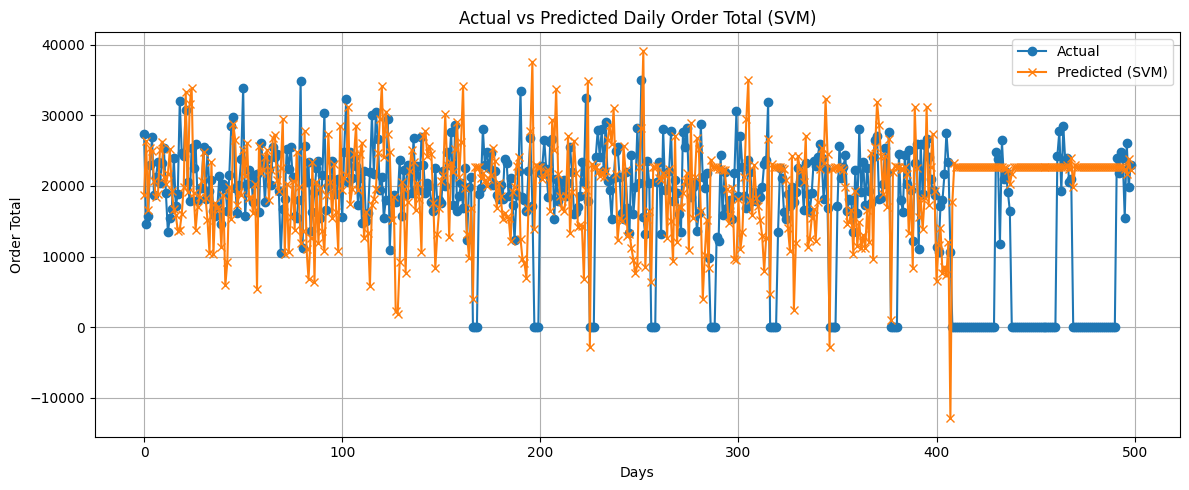

In [11]:
# 7. Trực quan hóa kết quả
plt.figure(figsize=(12, 5))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted (SVM)', marker='x')
plt.title('Actual vs Predicted Daily Order Total (SVM)')
plt.xlabel('Days')
plt.ylabel('Order Total')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()